In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, matthews_corrcoef, log_loss, roc_curve

def random_forest(csv_file, scale=False):
    data = pd.read_csv(csv_file, sep=',')
    y = data['quality'].apply(lambda v: 1 if v >= 7 else 0)
    X = data.drop('quality', axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    #Define Random Forest with class weights
    base_rf = RandomForestClassifier(n_jobs=-1,random_state=42,
                                class_weight='balanced_subsample'
    )
    #Random Hyperparameters search
    param_dist = { 'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 0.5], 'bootstrap': [True, False] }

    search = RandomizedSearchCV(
        base_rf, param_distributions=param_dist,
        n_iter=5, cv=3, scoring='accuracy',
        random_state=42, n_jobs=-1, verbose=1
    )
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_
    #Predictions
    y_pred_probs = best_rf.predict_proba(X_test)[:, 1]

    #Optimal threshold via ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_opt = (y_pred_probs >= optimal_threshold).astype(int)

    #Metrics computation
    auc = roc_auc_score(y_test, y_pred_probs)
    mcc = matthews_corrcoef(y_test, y_pred_opt)
    ll  = log_loss(y_test, y_pred_probs)

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Random Forest')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    thresholds_mcc = np.linspace(0, 1, 100)
    mcc_scores = [matthews_corrcoef(y_test, (y_pred_probs >= t).astype(int)) for t in thresholds_mcc]

    plt.figure()
    plt.plot(thresholds_mcc, mcc_scores, label='MCC')
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('MCC')
    plt.title('MCC vs Threshold - Random Forest')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"AUC-ROC    : {auc:.4f}")
    print(f"MCC        : {mcc:.4f}")
    print(f"Log-Loss   : {ll:.4f}")
    print(f"Threshold  : {optimal_threshold:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


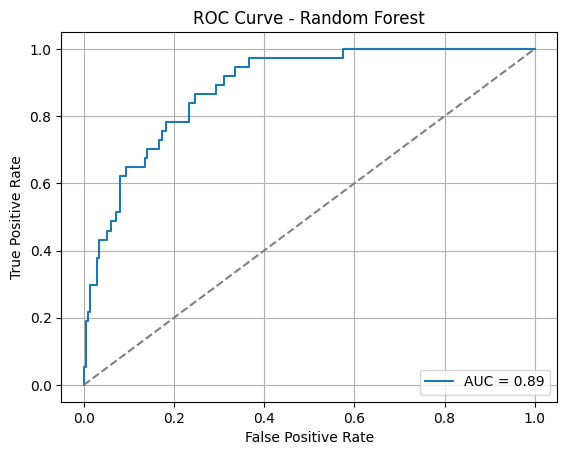

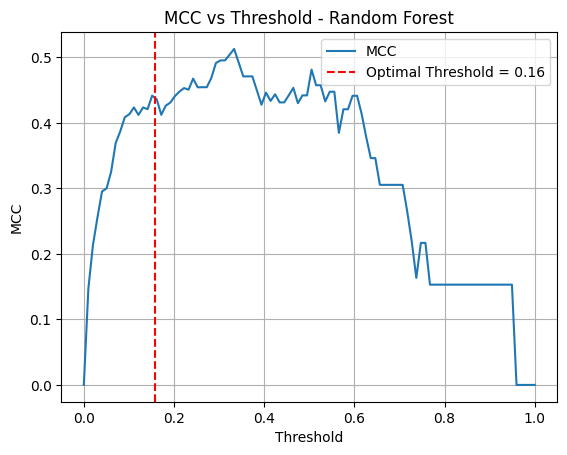

AUC-ROC    : 0.8859
MCC        : 0.4503
Log-Loss   : 0.2678
Threshold  : 0.1577


In [49]:
metrics = random_forest("../cleanDatasets/winequality-red_cleaned.csv", scale=True)

#metrics = random_forest("../cleanDatasets/winequality-white_cleaned.csv", scale=True)